<center>

### COSC2753 - Machine Learning

# **Recommend System**

<center>────────────────────────────</center>
&nbsp;

# I. Introduction

In this notebook, we will develop a recommendation system which is capable of recommending 10 furniture images in the dataset which is similar to the input furniture image from users. This process will involve the following steps:
- **Feature extraction**: Develop a new CNN architecture tailored specifically for extracting salient feature vectors from each image present in the dataset. This meticulously crafted CNN model will serve as our tool to uncover and encode the distinctive characteristics inherent in every image, capturing nuances and patterns essential for subsequent analysis and recommendation tasks.

- **Image Classification**: Leverage the meticulously chosen CNN model identified during Task 1 to delve into the task of categorizing the input furniture image. This process involves subjecting the image to the learned capabilities of the CNN, allowing it to discern and assign the most fitting category label from the available classification options. Through this classification step, we harness the power of deep learning to accurately identify and categorize furniture items, enabling subsequent steps in our recommendation system pipeline to operate with precision and efficacy.

- **K-means clustering**: By iteratively optimizing the cluster centroids to minimize the within-cluster variance, K-means identifies coherent clusters within the dataset. In the context of our recommendation system, this clustering technique helps to group furniture images based on their intrinsic similarities.

- **Recommendation**: : With the foundational work of feature extraction, image classification, and K-means clustering laid out, we transition to the recommendation phase. Here, we leverage the clustered groups of furniture images to tailor recommendations for users. To measure the similarity between pairs of furniture items, we select **Cosine similarity** as our **Metric of "similarity"**, renowned for its effectiveness in capturing the angle between two vectors in a high-dimensional space. By computing the cosine similarity between feature vectors extracted from furniture images, we can quantify the degree of resemblance or likeness between items. This metric serves as a cornerstone in our recommendation engine, enabling us to identify and suggest items that exhibit the highest degree of similarity.

# II. Importing Libraries

In [1]:
# # Import necessary packages
import pandas as pd  # Data manipulation
import sys  # System specific parameters and functions
import importlib  # Importing modules
import tensorflow as tf  # Machine learning
from sklearn.model_selection import train_test_split  # Split for train and test
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image data generator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from sklearn.metrics import classification_report  # Metrics
from sklearn.utils.class_weight import compute_class_weight  # Class weights
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Reload modules
sys.path.append("../../")  # Root directory
modules_to_reload = ["scripts.leon", "scripts.styler"]

# Reload modules if they have been modified
missing_modules = []

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
    else:
        missing_modules.append(module_name)

# Recache missing modules
if missing_modules:
    print(f"Modules {missing_modules} not found. Recaching...")

# Import user-defined scripts
# from scripts.leon import Leon  # Leon class
# from scripts.styler import Styler  # Styler class

# # Configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.precision", 3)
import tensorflow as tf

print("TF version:", tf.__version__)
print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

CLASS_LABELS = ["beds", "chairs", "dressers","lamps","sofas","tables"]

# Initialize objects
# leon = Leon()
# styler = Styler()

2024-05-21 17:07:17.271070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 17:07:17.271122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 17:07:17.272049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 17:07:17.277749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 17:07:17.986425: W tensorflow/compiler/tf2

Modules ['scripts.leon', 'scripts.styler'] not found. Recaching...
TF version: 2.15.0
GPU is available


2024-05-21 17:07:19.753768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:07:19.776564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:07:19.776795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# III. Implementation

## 1. Load database for recommendation system

The recommendation system will incorporate raw image files, excluding any augmented images or duplicated data. Our dataset construction process involves amalgamating both the training and testing datasets while omitting any augmented images.

In [2]:
# Load train dataset
df_train = pd.read_csv("../../data_2/processed/train.csv",delimiter=',')

# Load test dataset
df_test = pd.read_csv("../../data_2/test/test.csv",delimiter=',')

# Combine the train and test datasets and filter out the augmented images
if 'Path' in df_train.columns and 'Path' in df_test.columns:
    # Concatenate the dataframes vertically
    combined_df = pd.concat([df_train, df_test], ignore_index=True)

    # Filter the combined dataframe to exclude rows where the 'Path' column contains "aug_"
    filtered_df = combined_df[~combined_df['Path'].str.contains('aug_')]

In [3]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75697 entries, 6 to 362080
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Path      75697 non-null  object 
 1   Category  75697 non-null  object 
 2   Style     75697 non-null  object 
 3   Width     75697 non-null  int64  
 4   Height    75697 non-null  int64  
 5   MinValue  75697 non-null  int64  
 6   MaxValue  75697 non-null  int64  
 7   StdDev    75697 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 5.2+ MB


This figure aligns precisely with the number of images obtained during the pre-processing phase before splitting.

## 2. Feature Extraction

### 2.1. Construct a CNN model for feature extraction

In this part, we will build a new Convolutional Neural Network (CNN) to extract feature vectors from images. Given the considerable size of our dataset, we have opted to set the dimensionality of the feature vectors to **128**. This will help to capture the essential characteristics of each image while ensuring computational efficiency and scalability in handling the vast volume of data.

In [4]:
# Parameters
INPUT_DIM = (256,256, 3)
FEATURE_VECTOR_DIM = 128

We will construct a new CNN model to extract feature:

In [5]:
feat_extractor = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(FEATURE_VECTOR_DIM),
])


feat_extractor.compile(optimizer='adam', loss='mse')


2024-05-21 17:07:20.362844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:07:20.363161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:07:20.363367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:07:20.490277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 17:07:20.490489: I external/local_xla/xla/stream_executor

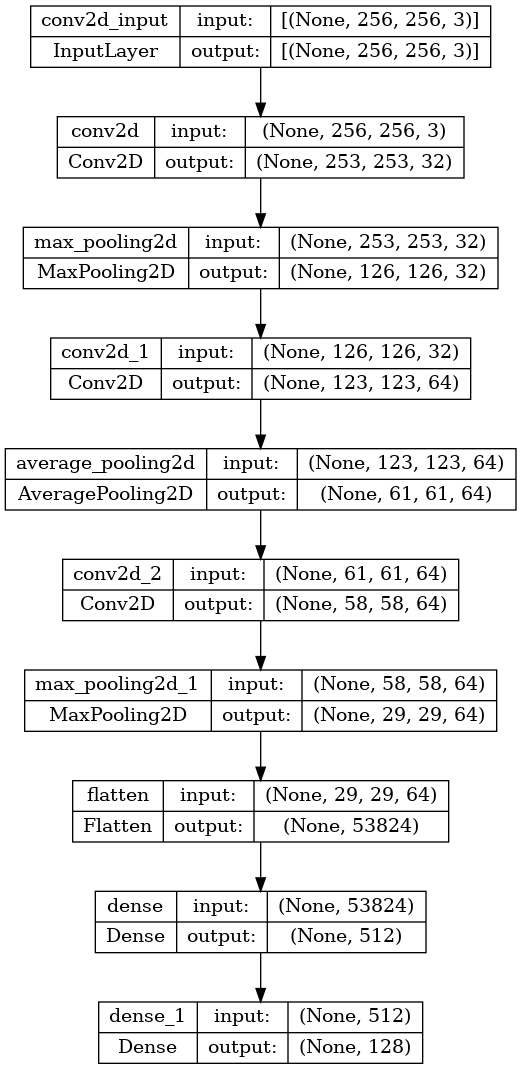

In [6]:
tf.keras.utils.plot_model(feat_extractor, show_shapes=True)

In [7]:
feat_extractor.save("feature_extract", overwrite=True)

2024-05-21 17:07:21.224915: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 110231552 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: feature_extract/assets


INFO:tensorflow:Assets written to: feature_extract/assets


### 2.2. Extract feature vector for all images

Next, we will loop through all images from the dataset and extract its feature vector.

In [8]:
## Initialize the feature vector dictionary
feature_vector = {'Path': [], 'Category': []}
for i in range(FEATURE_VECTOR_DIM):
    feature_vector[f'Feature {i}'] = []

total_images = len(filtered_df)
processed_images = 0

## Iterate over the rows of the filtered dataframe
for i, row in filtered_df.iterrows():
    processed_images += 1
    progress_percent = (processed_images / total_images) * 100
    print(f'Processing image {processed_images}/{total_images} - {progress_percent:.2f}% complete', end='\r')

    feature_vector['Path'].append(row['Path'])
    feature_vector['Category'].append(row['Category'])
    with Image.open(row['Path']) as ref:  # Open the image from the row
        ref = ref.resize((256, 256))  # Resize the image if needed
        ref_array = np.array(ref)  # Convert PIL image to NumPy array
        ref_array = ref_array / 255.0  # Normalize pixel values to [0, 1]
        ref_tensor = tf.convert_to_tensor(ref_array, dtype=tf.float32)  # Convert NumPy array to TensorFlow tensor
        ref_tensor = tf.expand_dims(ref_tensor, axis=0)  # Add batch dimension

        ref_feature_vector = feat_extractor.predict(ref_tensor, verbose=0)

        for j, feature in enumerate(ref_feature_vector.reshape(-1)):
            feature_vector[f'Feature {j}'].append(feature)

2024-05-21 17:07:21.618632: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-21 17:07:21.759076: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 17:07:22.129176: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


### 2.3. Convert to dataframe and save as .csv file

In [ ]:
# Convert to dataframe
df_feature_vector = pd.DataFrame(feature_vector)
df_feature_vector.to_csv("../../data_2/feature_vector.csv", index=False)

In [ ]:
df_feature_vector = pd.read_csv("../../data_2/feature_vector.csv",delimiter=',')
df_feature_vector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75694 entries, 0 to 75693
Columns: 130 entries, Path to Feature 127
dtypes: float64(128), object(2)
memory usage: 75.1+ MB


## 3. Image Classification
In this step, we'll utilize the CNN model trained in Task 1 to classify the category of a user-input image

### 3.1. **classify** function

Initially, the image will be resized to dimensions of **256x256** pixels and then normalized so that pixel values fall within the range of 0 and 1. Subsequently, the CNN model will make predictions regarding the image's category.

In [ ]:
# Define the classify function
def classify(image_path: str, model: tf.keras.Model, verbose: bool = False, return_original: bool = True) -> tuple:
    """
    Uses a trained machine learning model to classify an image loaded from disk.

    :param image_path: Path to the image to be classified.
    :param model: Pre-loaded classifier model to be used.
    :param verbose: Verbose output.
    :param return_original: Whether to return the original image or the processed image.
    :return: The original/processed image (PIL.image) and its classification (str).
    """

    # Load the image from the given path
    im_original = Image.open(image_path)

    # Resize the image to the target size
    im_processed = im_original.resize((256, 256))

    # Convert the PIL image to a NumPy array and normalize pixel values to [0, 1]
    im_array = np.array(im_processed) / 255.0

    # Convert the NumPy array to a TensorFlow tensor and add a batch dimension
    im_tensor = tf.convert_to_tensor(im_array, dtype=tf.float32)
    im_tensor = tf.expand_dims(im_tensor, axis=0)

    # Predict the class of the processed image
    pred = model.predict(im_tensor, verbose=1 if verbose else 0)

    # Get the index of the predicted class
    pred_class_idx = tf.argmax(pred, axis=1).numpy()[0]

    # Get the label of the predicted class
    # Ensure that CLASS_LABELS is defined elsewhere in your code
    pred_class_label = CLASS_LABELS[pred_class_idx]

    # Return the original or processed image along with the predicted class label
    if return_original:
        return im_original, pred_class_label
    else:
        return im_processed, pred_class_label

### 3.2. Load CNN model for image classification 

In this part, we just simply load the CNN model that has been trained from Task 1.

In [ ]:
# Load CNN model (without compiling)
cnn = tf.keras.models.load_model("./cache_cnn/best_cnn.h5",compile=False)

# Compile model
cnn.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
# Summarise the model
cnn.summary()

2024-05-21 16:24:34.437198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 16:24:34.437536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 16:24:34.437759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 16:24:34.554068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 16:24:34.554317: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0

## 4. Unsupervised Learning Model: K-Mean Clustering

### 4.1. Select n-cluster

To find the most optimal n-cluster value, we will implement the Elbow approach.

In [ ]:
## Select a n_cluster value with KMeans and Elbow Method
from sklearn.cluster import KMeans

# Drop the 'Path' and 'Category' columns
distortions = []
X = df_feature_vector.drop(columns=['Path', 'Category'])
K = range(1,11)
for k in K:
    kmeans = KMeans(n_clusters= k, init="k-means++", n_init='auto')
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

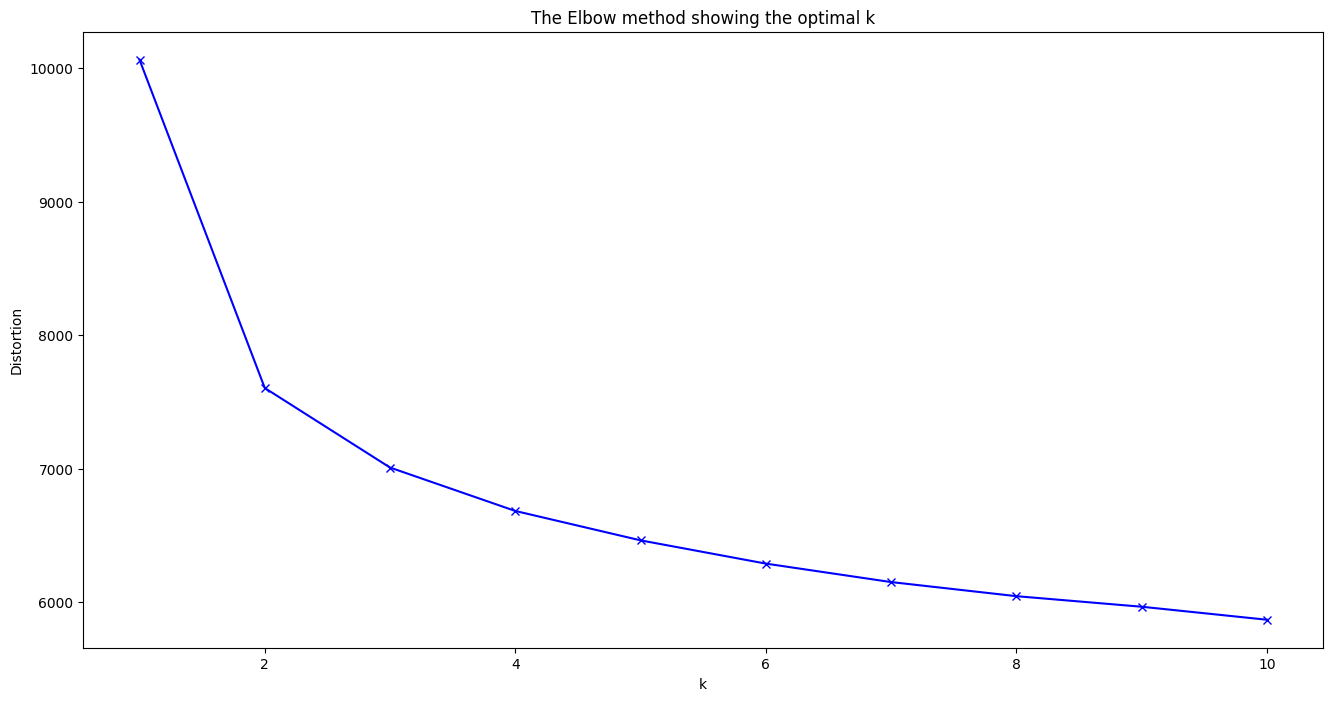

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow method showing the optimal k')
plt.show()

- **Observation**: From the diagram above, we can observe that the optimal k value is 3, from that point onwards the distortion gradually decreases. This is the elbow point of the graph and we will use **n_cluster=3**

## 5. Recommendation System

### 5.1. Set up parameters


In [ ]:
## Setup parameters for KMeans model
selected_n_clusters = 3
clu = KMeans(n_clusters=selected_n_clusters, init="k-means++", n_init='auto')

# Setup the number of samples
sample_number = 8
num_recommendations = 10

### 5.2. Get random images to test from the dataset

We will get some random images from the dataset. For the testing reason, we will get 8 images.

/tmp/ipykernel_25518/267135348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Path"] = filtered_df["Path"].str.replace("../data/", "../data_1/")


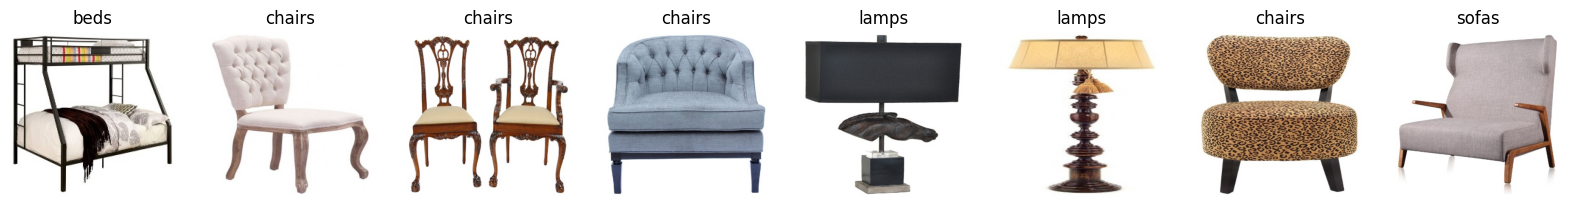

In [ ]:
# Sample 8 random images from filtered_df
random_images = filtered_df.sample(sample_number)

# Create subplots
figure, axes = plt.subplots(1, sample_number, figsize=(20, 5))

# Iterate over each randomly selected image
for idx, (img_idx, img_row) in enumerate(random_images.iterrows()):
    # Load the image using PIL
    with Image.open(img_row['Path']) as image:
        # Display the image
        axes[idx].imshow(image)
        axes[idx].set_title(img_row['Category'], fontsize=12)
        axes[idx].axis('off')

# Show the plot
plt.show()

### 5.3. Recommend phase

In [ ]:
results = []

## Load the feature extractor model
fe = tf.keras.models.load_model("feature_extract")

## Iterate over each randomly selected image
for ref_path in random_images['Path']:
    with Image.open(ref_path) as ref:  # Open the image from the row
        # Classify the image into category
        ref_processed, ref_class = classify(f'{ref_path}', cnn, return_original=False)
        recommendation = df_feature_vector[df_feature_vector['Category'] == ref_class]

        # Extract reference image feature vector
        ref_processed = np.squeeze(ref_processed)
        ref_feature_vector = fe.predict(
            tf.expand_dims(ref_processed, axis=0),
            verbose=0
        )
        ref_feature_vector = ref_feature_vector.astype(float)
        ref_feature_vector = ref_feature_vector.reshape(1, -1)

        # Cluster reference image
        clu.fit(recommendation.drop(['Path', 'Category'], axis='columns').values)
        ref_cluster = clu.predict(ref_feature_vector)
        ref_cluster_indices = np.where(clu.labels_ == ref_cluster)[0]
        recommendation = recommendation.iloc[ref_cluster_indices]

        # Exclude the original image from the recommendation set
        recommendation = recommendation[recommendation['Path'] != ref_path]

        # Rank cluster and produce top cosine similarity recommendations
        cosine_similarities = cosine_similarity(ref_feature_vector, recommendation.drop(['Path', 'Category'], axis='columns'))

        # Sort the cosine similarities in descending order
        sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())
        top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
        recommendation = recommendation.iloc[top_ref_cluster_indices]

        results.append(recommendation['Path'].values)

print(results)


2024-05-21 16:24:57.058358: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-21 16:24:57.404937: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 16:24:58.439634: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[array(['../../data_1/raw/Furniture_Data/Furniture_Data/tables/Modern/10753modern-coffee-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Craftsman/26053craftsman-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Traditional/28862traditional-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Midcentury/44826midcentury-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Modern/8856modern-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Farmhouse/30460farmhouse-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Modern/8855modern-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Contemporary/3604contemporary-side-tables-and-end-tables.jpg',
       '../../data_1/raw/Furniture_Data/Furniture_Data/tables

## 6. Evaluation

We will plot to check the result of our recommendation system:

FileNotFoundError: [Errno 2] No such file or directory: '../../data_1/raw/Furniture_Data/Furniture_Data/tables/Craftsman/26053craftsman-side-tables-and-end-tables.jpg'

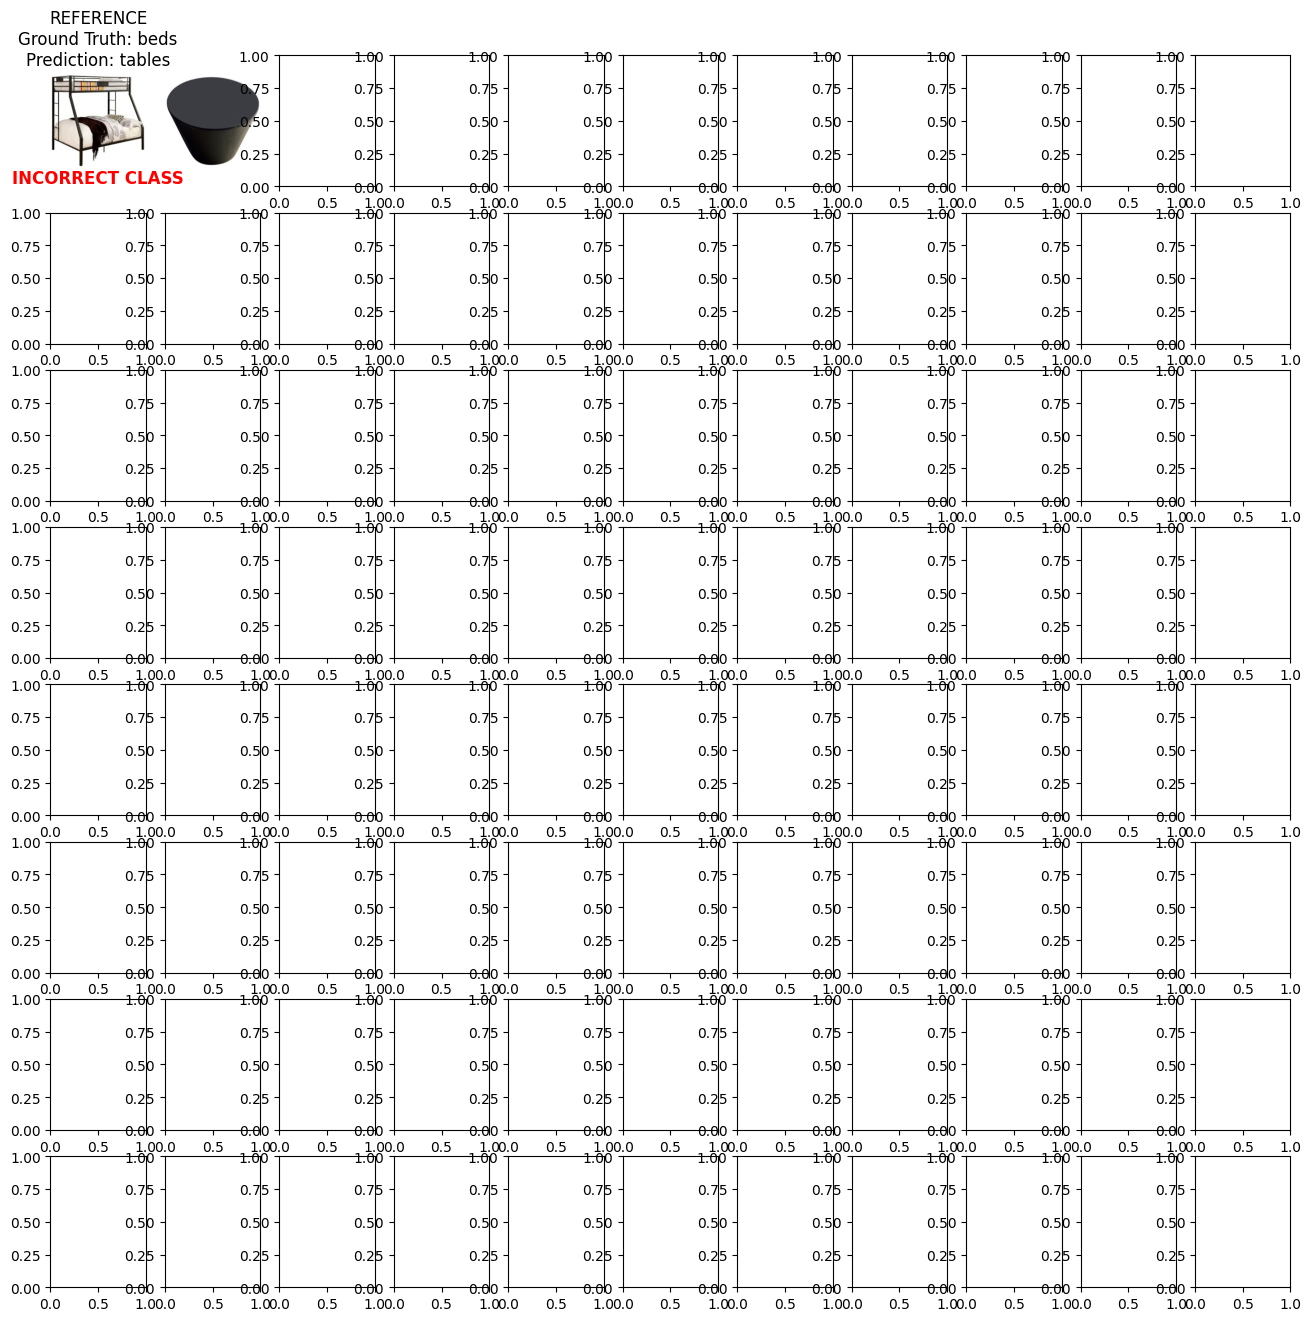

In [ ]:
fig, ax = plt.subplots(8, 11, figsize=(16, 16))
for i, ref_path in enumerate(random_images['Path']):
    with Image.open(f'{ref_path}') as ref:
        true_label = ref_path.split('/')[-3]
        _, predicted_label = classify(f'{ref_path}', cnn)

        ax[i][0].imshow(ref)
        ax[i][0].set_title(
            f'REFERENCE\n'
            f'Ground Truth: {true_label}\n'
            f'Prediction: {predicted_label}',
            fontsize=12
        )
        ax[i][0].text(
            0.5, -0.08, f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
            horizontalalignment='center',
            verticalalignment='center_baseline',
            transform=ax[i][0].transAxes,
            fontsize=12,
            color='green' if true_label == predicted_label else 'red',
            weight='bold'
        )
        ax[i][0].axis('off')

    for j, rec_path in enumerate(results[i], start=1):
        with Image.open(f'{rec_path}') as rec:
            ax[i][j].imshow(rec)
            ax[i][j].axis('off')


plt.tight_layout()
plt.show()

We can observe that the recommendation system works with very high accuracy.